请你添加一个for循环，分别训练7天的增长率density_growth模型，包括今天到明天（T+1）的增长率、今天到后天（T+2）的增长率、今天到大后天（T+3）的增长率、...、今天到（T+7）的增长率。

这样，在predict的时候，就能同时预测7天的增长率density_growth，包括今天到明天（T+1）的增长率、今天到后天（T+2）的增长率、今天到大后天（T+3）的增长率、...、今天到（T+7）的增长率。

然后就能基于今天的density，乘上增长率density_growth，得到未来的连续7天的density。具体而言，明天的density是基于今天，后天的density也是基于今天，大后天的density也是基于今天，以此类推。

对于最终得到的这些未来的连续7天的density，我们还可以分别计算RSME。一般来讲明天（T+1）的density的RSME会更准确，而（T+7）的density的RSME误差较大。

需要你注意：
- 训练的时候需要调用create_sequence_for_date，构建高维的train_sequences.append(seq)，seq包含了60天的数据
- 预测的时候，每一个step，也就是每进入新的一天：都需要加入今天的数据，弹出60天以前的数据。

请你按照下面的建议修改：
1. **数据要求说明**：
- 我们目前的数据集范围：2021年1月1日 - 2024年5月31日



2. **数据集划分建议**：
```python
# 使用固定日期划分训练集和测试集，而不是固定比例
```
  - 训练集：2021年1月1日 - 2024年1月31日。比如需要2021年1月~2月60天的数据来训练2021年3月1日的density_growth（T+1），并且还需要训练2021年3月1日的density_growth（T+2）....，并且还需要训练2021年3月1日的density_growth（T+30）.所以训练集需要在前段预留60天，后段预留30天。
  - 测试集：2023年11月1日 - 2024年5月31日。比如需要2023年11月~12月60天的数据来预测2024年1月1日的density_growth（T+1），并且还需要预测2024年1月1日的density_growth（T+2）....，并且还需要预测2024年1月1日的density_growth（T+30）.所以测试集需要在前段预留60天，后段预留30天。

3. **建议添加数据检查代码**：
```python
# 在训练开始前添加以下代码
print(f"数据集总长度: {len(df)} 天")
print(f"训练集起始日期: {df.index[0]}")
print(f"训练集结束日期: {df.index[train_size-1]}")
print(f"测试集起始日期: {df.index[train_size]}")
print(f"测试集结束日期: {df.index[-1]}")

# 检查是否有足够的历史数据
first_valid_date = df.index[seq_length]
print(f"第一个可用于训练的日期: {first_valid_date}")
print(f"可用于训练的天数: {train_size - seq_length} 天")
```


数据集总长度: 1064 天
数据集起始日期: 2021-01-01 00:00:00
数据集结束日期: 2024-05-31 00:00:00
训练集起始日期: 2021-01-01 00:00:00
训练集结束日期: 2024-01-31 00:00:00
测试集起始日期: 2023-11-01 00:00:00
测试集结束日期: 2024-05-31 00:00:00
第一个可用于训练的日期: 2021-03-02 00:00:00
可用于训练的天数: 883 天

训练 T+1 天的模型
Epoch [50/300], Loss: 0.0003
Epoch [100/300], Loss: 0.0006
Epoch [150/300], Loss: 0.0003
Epoch [200/300], Loss: 0.0005
Epoch [250/300], Loss: 0.0002
Epoch [300/300], Loss: 0.0008

训练 T+2 天的模型
Epoch [50/300], Loss: 0.0011
Epoch [100/300], Loss: 0.0003
Epoch [150/300], Loss: 0.0003
Epoch [200/300], Loss: 0.0001
Epoch [250/300], Loss: 0.0001
Epoch [300/300], Loss: 0.0002

训练 T+3 天的模型
Epoch [50/300], Loss: 0.0006
Epoch [100/300], Loss: 0.0002
Epoch [150/300], Loss: 0.0002
Epoch [200/300], Loss: 0.0003
Epoch [250/300], Loss: 0.0003
Epoch [300/300], Loss: 0.0001

训练 T+4 天的模型
Epoch [50/300], Loss: 0.0009
Epoch [100/300], Loss: 0.0027
Epoch [150/300], Loss: 0.0004
Epoch [200/300], Loss: 0.0002
Epoch [250/300], Loss: 0.0002
Epoch [300/300], Loss: 0

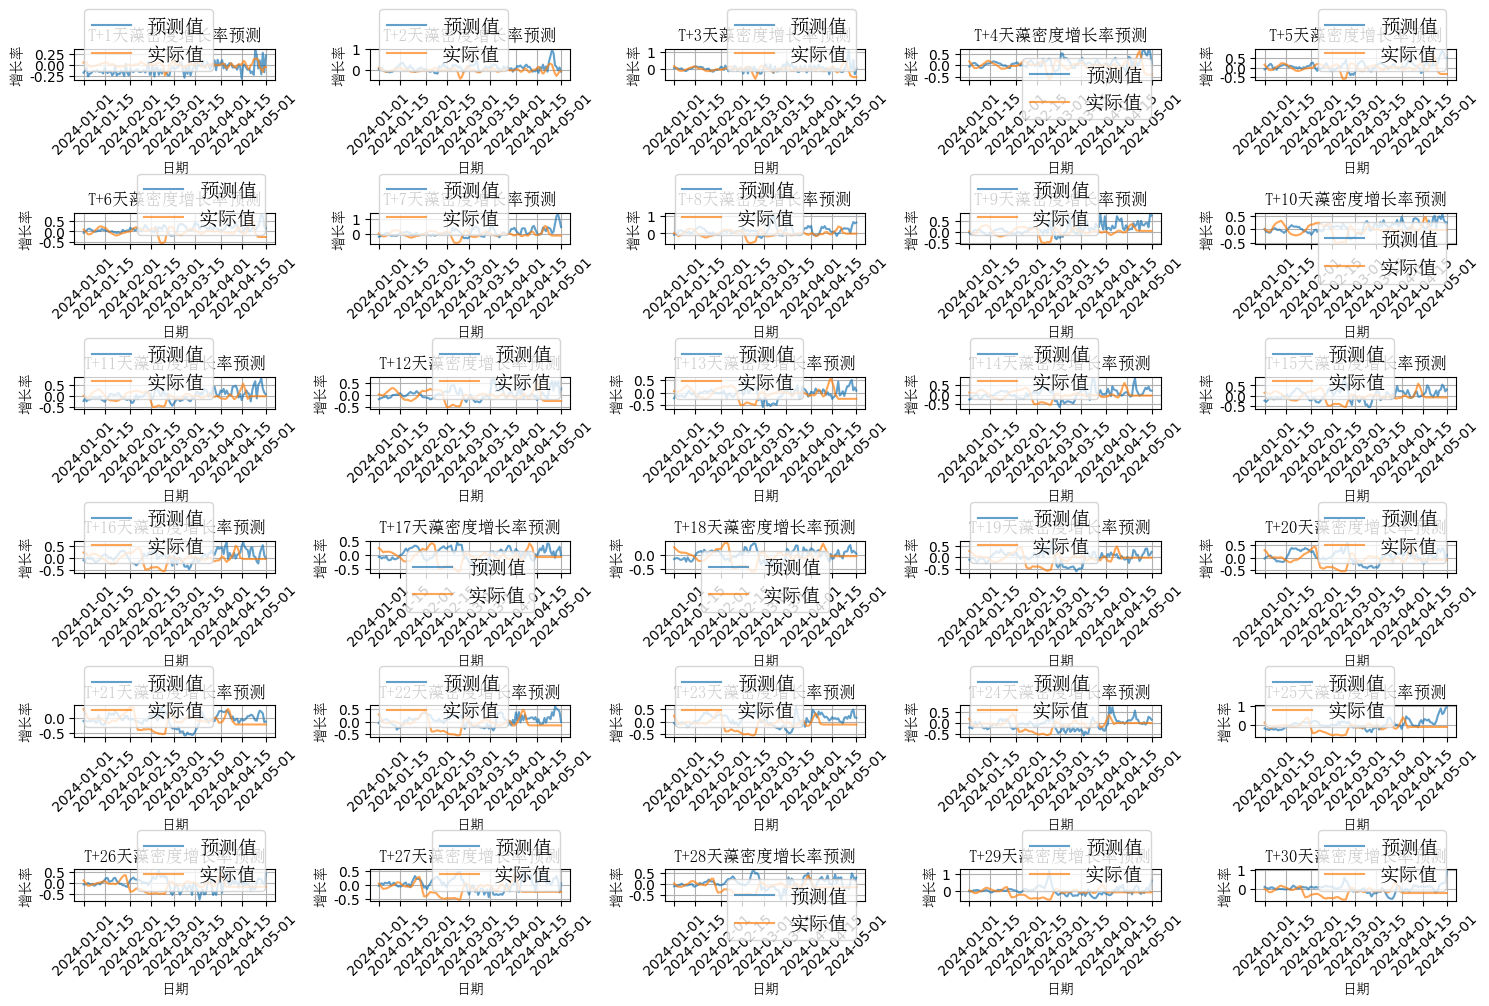

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
from torch.optim.lr_scheduler import OneCycleLR

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# 读取数据
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 剔除6-7月的数据
df = df[~df.index.month.isin([6, 7])]

# 计算T+1到T+30的增长率
for days in range(1, 31):
    df[f'density_growth_{days}d'] = (df['density'].shift(-days) - df['density']) / df['density']
    df[f'density_growth_{days}d'] = df[f'density_growth_{days}d'].interpolate(method='linear')
    window_size = 3
    df[f'density_growth_{days}d_smoothed'] = df[f'density_growth_{days}d'].rolling(window=window_size, center=True).mean()
    df[f'density_growth_{days}d_smoothed'] = df[f'density_growth_{days}d_smoothed'].interpolate(method='linear')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

def create_sequence_for_date(data, date_index, seq_length):
    """为指定日期创建输入序列"""
    if date_index < seq_length:
        return None
    return data[date_index - seq_length:date_index]

# 基础特征
base_features = ['temperature', 'pH', 'oxygen', 'permanganate', 'TN', 'conductivity', 
                'turbidity', 'chla', 'density', 'GMT_0000_PAR', 'GMT_0300_PAR', 
                'GMT_0900_PAR', 'GMT_2100_PAR', 'MPAR', 'APAR', 'PPDI', 'PAI',
                'eutrophication_index', 'temp_ph_interaction', 'wind_north',
                'weather_heavy_rain', 'weather_temp_index', 'temperature_high',
                'strong_wind']

# 为每个预测天数创建一个模型和数据集
models = {}
predictions_all = {}
actual_values_all = {}

# 使用固定日期划分训练集和测试集
train_start_date = '2021-01-01'
train_end_date = '2024-01-31'
test_start_date = '2023-11-01'
test_end_date = '2024-05-31'

# 数据集检查
print(f"数据集总长度: {len(df)} 天")
print(f"数据集起始日期: {df.index[0]}")
print(f"数据集结束日期: {df.index[-1]}")

# 获取训练集和测试集的索引
train_mask = (df.index >= train_start_date) & (df.index <= train_end_date)
test_mask = (df.index >= test_start_date) & (df.index <= test_end_date)
train_size = sum(train_mask)

print(f"训练集起始日期: {df.index[train_mask][0]}")
print(f"训练集结束日期: {df.index[train_mask][-1]}")
print(f"测试集起始日期: {df.index[test_mask][0]}")
print(f"测试集结束日期: {df.index[test_mask][-1]}")

seq_length = 60
# 检查是否有足够的历史数据
first_valid_date = df.index[seq_length]
print(f"第一个可用于训练的日期: {first_valid_date}")
print(f"可用于训练的天数: {train_size - seq_length} 天")

for days in range(1, 31):
    print(f"\n训练 T+{days} 天的模型")
    
    # 添加对应天数的增长率特征
    features = base_features + [f'density_growth_{days}d', f'density_growth_{days}d_smoothed']
    
    data = df[features].values
    data = np.nan_to_num(data, nan=0)
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # 使用固定日期划分的训练集和测试集数据
    train_data = scaled_data[train_mask]
    test_data = scaled_data[test_mask]
    
    # 构建训练序列
    train_sequences = []
    train_targets = []
    for i in range(seq_length, len(train_data)):
        seq = create_sequence_for_date(scaled_data, i, seq_length)
        if seq is not None:
            train_sequences.append(seq)
            train_targets.append(train_data[i, features.index(f'density_growth_{days}d_smoothed')])
    
    X_train = torch.FloatTensor(train_sequences)
    y_train = torch.FloatTensor(train_targets)
    
    train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # 初始化和训练模型
    model = LSTMModel(input_size=len(features), hidden_size=64, num_layers=2, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 300
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    models[days] = (model, scaler, features)
    
    # 预测阶段
    model.eval()
    predictions = []
    actual_values = []
    current_sequence = scaled_data[test_mask][0:seq_length]
    
    with torch.no_grad():
        for i in range(len(test_data)-days):
            current_sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
            pred = model(current_sequence_tensor)
            
            predictions.append(pred.item())
            actual_values.append(test_data[i+days, features.index(f'density_growth_{days}d_smoothed')])
            
            current_sequence = np.vstack([
                current_sequence[1:],
                test_data[i]
            ])
    
    # 反归一化预测结果
    pred_full_features = np.zeros((len(predictions), len(features)))
    actual_full_features = np.zeros((len(actual_values), len(features)))
    
    growth_idx = features.index(f'density_growth_{days}d_smoothed')
    pred_full_features[:, growth_idx] = np.array(predictions)
    actual_full_features[:, growth_idx] = np.array(actual_values)
    
    predictions_all[days] = scaler.inverse_transform(pred_full_features)[:, growth_idx]
    actual_values_all[days] = scaler.inverse_transform(actual_full_features)[:, growth_idx]

# 计算每个预测天数的RMSE
for days in range(1, 31):
    rmse = np.sqrt(mean_squared_error(actual_values_all[days], predictions_all[days]))
    print(f"T+{days}天预测的RMSE: {rmse:.4f}")

# 绘制2024年1-5月的预测结果
plt.figure(figsize=(15, 10))
start_date = '2024-01-01'
end_date = '2024-05-31'

# 获取测试集日期
test_dates = df.index[test_mask]

# 确保预测日期和预测值长度一致
prediction_dates = test_dates[:-30]  # 调整日期范围以适应最长的预测期
predictions_length = len(predictions_all[1])  # 使用第一天预测作为参考长度
prediction_dates = prediction_dates[-predictions_length:]  # 截取对应长度的日期

mask = (pd.to_datetime(prediction_dates) >= start_date) & (pd.to_datetime(prediction_dates) <= end_date)

for days in range(1, 31):
    plt.subplot(6, 5, days)
    plt.plot(pd.to_datetime(prediction_dates)[mask], predictions_all[days][-len(prediction_dates):][mask], 
             label='预测值', alpha=0.7)
    plt.plot(pd.to_datetime(prediction_dates)[mask], actual_values_all[days][-len(prediction_dates):][mask], 
             label='实际值', alpha=0.7)
    
    plt.title(f'T+{days}天藻密度增长率预测', fontproperties=chinese_font, fontsize=12)
    plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
    plt.ylabel('增长率', fontproperties=chinese_font, fontsize=10)
    plt.legend(prop=chinese_font)
    plt.grid(True)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()


In [3]:
# 计算每个预测天数的增长率RMSE
print("增长率预测的RMSE:")
for days in range(1, 31):  # 改为1-30天
    rmse = np.sqrt(mean_squared_error(actual_values_all[days], predictions_all[days]))
    print(f"T+{days}天预测的RMSE: {rmse:.4f}")

# 基于增长率计算2024年每一天未来30天的藻密度
density_predictions = {}  # 存储每一天的未来30天预测密度
density_actuals = {}     # 存储每一天的未来30天实际密度

# 获取密度特征的索引
density_idx = base_features.index('density')

# 获取2024年的日期范围
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-31')

# 对2024年的每一天进行预测
for current_date in dates_2024:
    # 找到当前日期在测试集中的索引
    date_idx = np.where(pd.to_datetime(test_dates) == current_date)[0]
    
    if len(date_idx) > 0:
        idx = date_idx[0]
        # 确保索引不超出范围
        if idx < len(test_data) and idx < len(predictions_all[1]) - 30:  # 减去30确保有足够的预测数据
            current_density = test_data[idx][density_idx]  # 获取当前日期的藻密度
            
            # 初始化当前日期的预测和实际值字典
            if current_date not in density_predictions:
                density_predictions[current_date] = {}
                density_actuals[current_date] = {}
            
            # 计算未来30天的藻密度，都是基于当前日期的密度
            for days in range(1, 31):  # 改为1-30天
                # 直接用当天的密度乘以对应天数的增长率
                if idx + days <= len(predictions_all[days]):  # 确保索引在有效范围内
                    density_predictions[current_date][days] = current_density * (1 + predictions_all[days][idx])
                    density_actuals[current_date][days] = current_density * (1 + actual_values_all[days][idx])


增长率预测的RMSE:
T+1天预测的RMSE: 0.1809
T+2天预测的RMSE: 0.1673
T+3天预测的RMSE: 0.2111
T+4天预测的RMSE: 0.2547
T+5天预测的RMSE: 0.2788
T+6天预测的RMSE: 0.2699
T+7天预测的RMSE: 0.3093
T+8天预测的RMSE: 0.3131
T+9天预测的RMSE: 0.2871
T+10天预测的RMSE: 0.2639
T+11天预测的RMSE: 0.2962
T+12天预测的RMSE: 0.3181
T+13天预测的RMSE: 0.2973
T+14天预测的RMSE: 0.3292
T+15天预测的RMSE: 0.3551
T+16天预测的RMSE: 0.3164
T+17天预测的RMSE: 0.3378
T+18天预测的RMSE: 0.3029
T+19天预测的RMSE: 0.3136
T+20天预测的RMSE: 0.3097
T+21天预测的RMSE: 0.2886
T+22天预测的RMSE: 0.2914
T+23天预测的RMSE: 0.3051
T+24天预测的RMSE: 0.2734
T+25天预测的RMSE: 0.2988
T+26天预测的RMSE: 0.3090
T+27天预测的RMSE: 0.3220
T+28天预测的RMSE: 0.3189
T+29天预测的RMSE: 0.3206
T+30天预测的RMSE: 0.3181



2024年藻密度预测的RMSE:
T+1天预测的RMSE: 0.0093
T+2天预测的RMSE: 0.0087
T+3天预测的RMSE: 0.0095
T+4天预测的RMSE: 0.0124
T+5天预测的RMSE: 0.0142
T+6天预测的RMSE: 0.0143
T+7天预测的RMSE: 0.0163
T+8天预测的RMSE: 0.0167
T+9天预测的RMSE: 0.0155
T+10天预测的RMSE: 0.0146
T+11天预测的RMSE: 0.0165
T+12天预测的RMSE: 0.0168
T+13天预测的RMSE: 0.0176
T+14天预测的RMSE: 0.0202
T+15天预测的RMSE: 0.0234
T+16天预测的RMSE: 0.0194
T+17天预测的RMSE: 0.0224
T+18天预测的RMSE: 0.0200
T+19天预测的RMSE: 0.0215
T+20天预测的RMSE: 0.0205
T+21天预测的RMSE: 0.0203
T+22天预测的RMSE: 0.0177
T+23天预测的RMSE: 0.0199
T+24天预测的RMSE: 0.0188
T+25天预测的RMSE: 0.0178
T+26天预测的RMSE: 0.0229
T+27天预测的RMSE: 0.0210
T+28天预测的RMSE: 0.0227
T+29天预测的RMSE: 0.0250
T+30天预测的RMSE: 0.0223


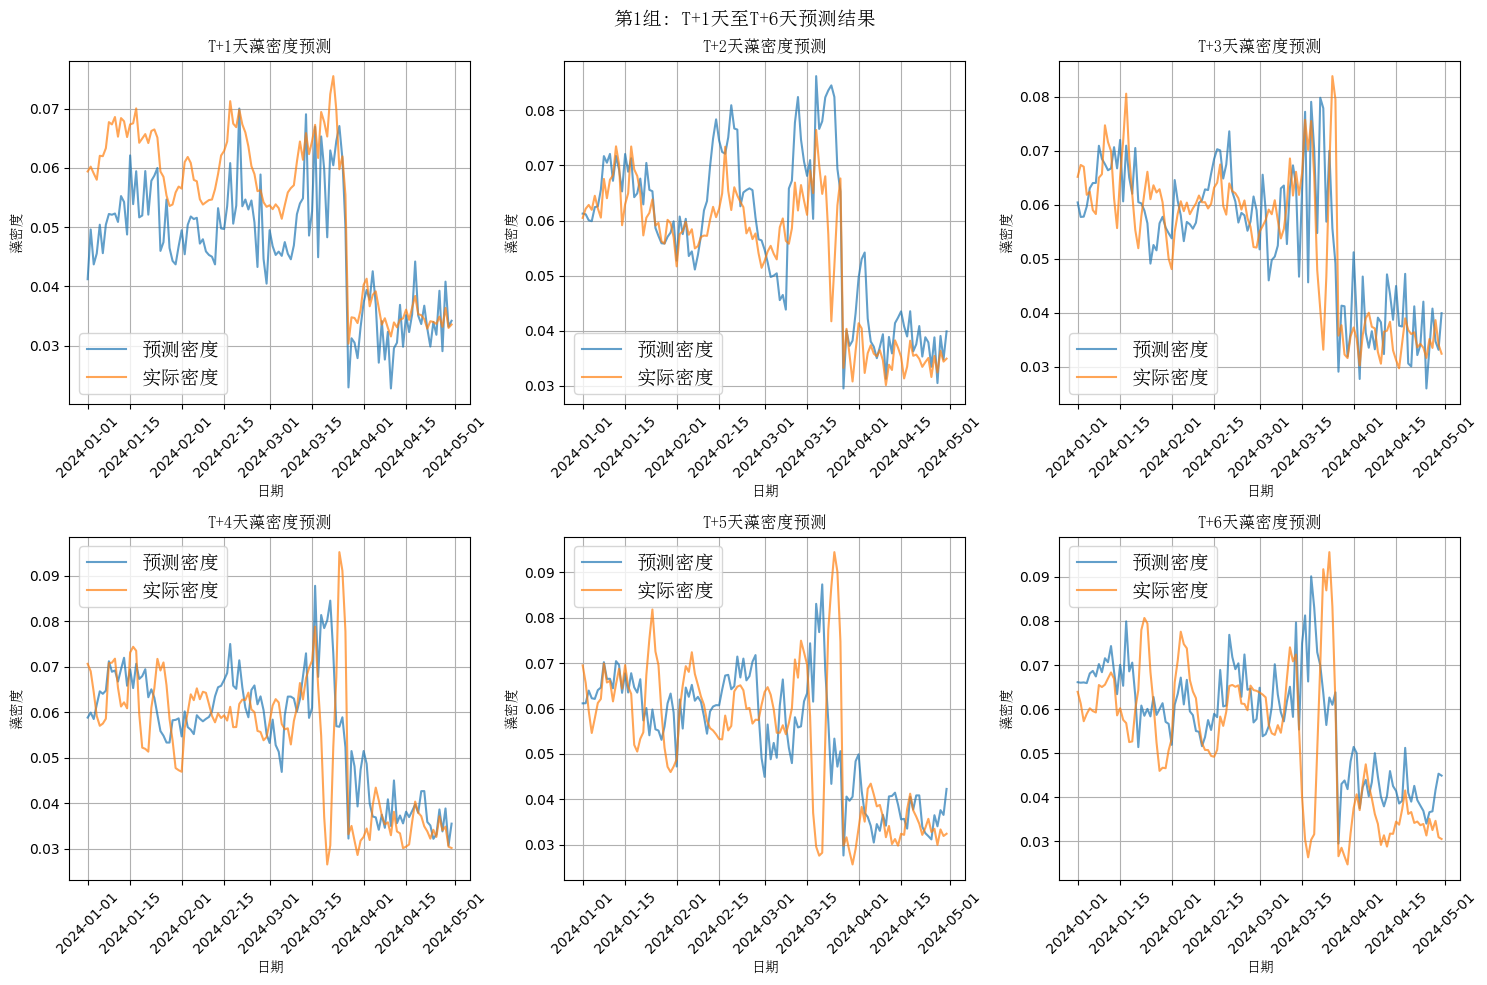

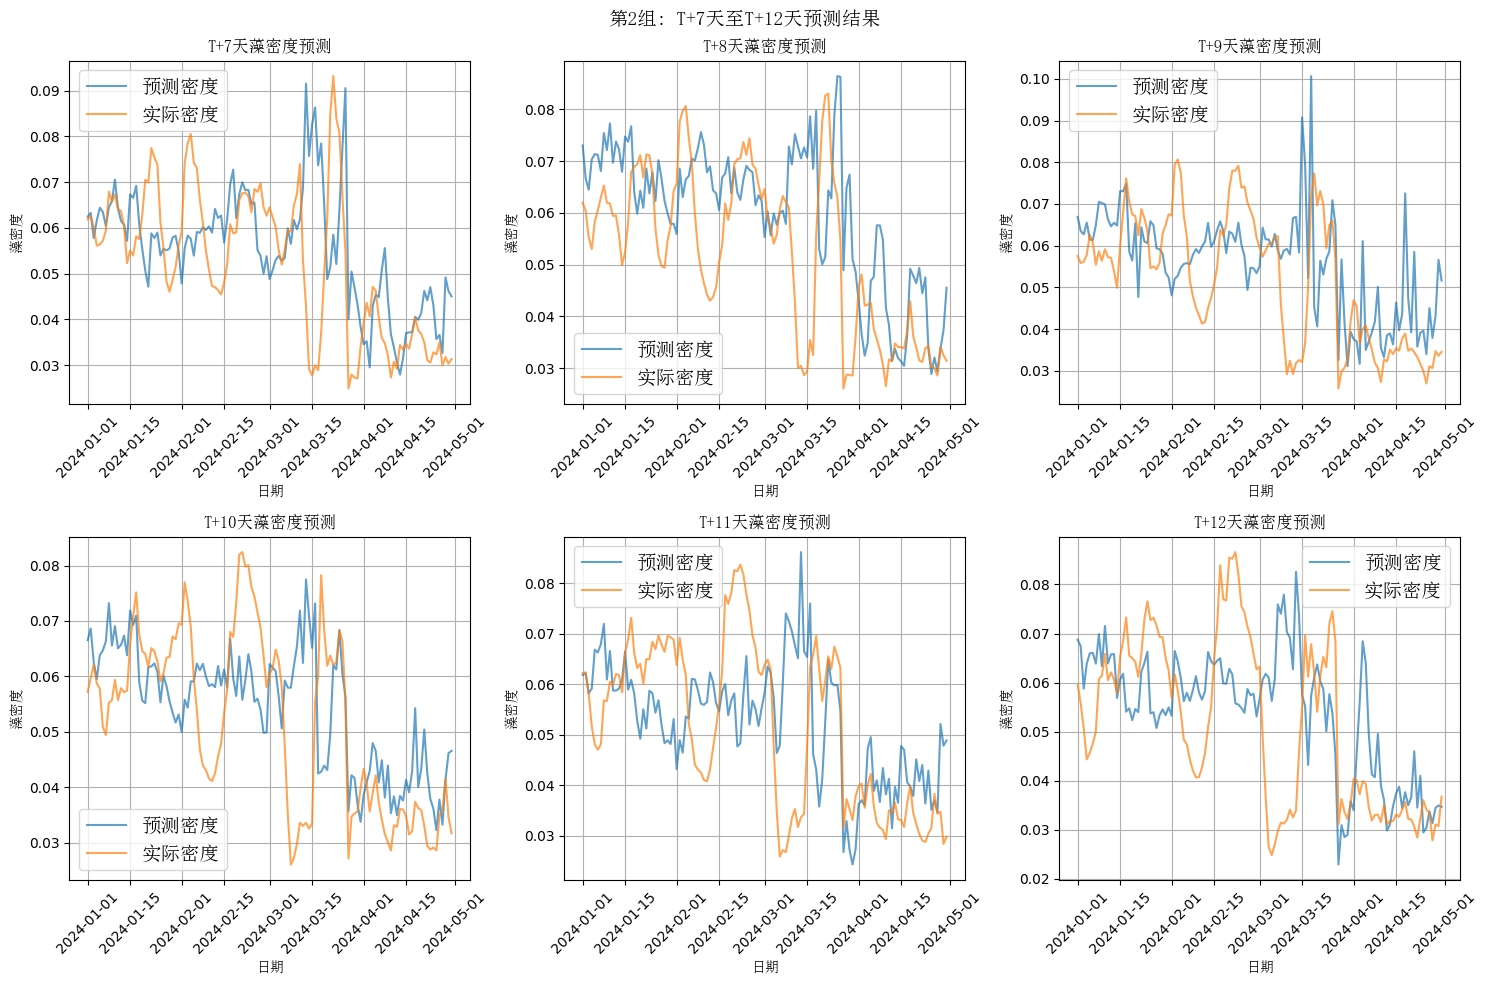

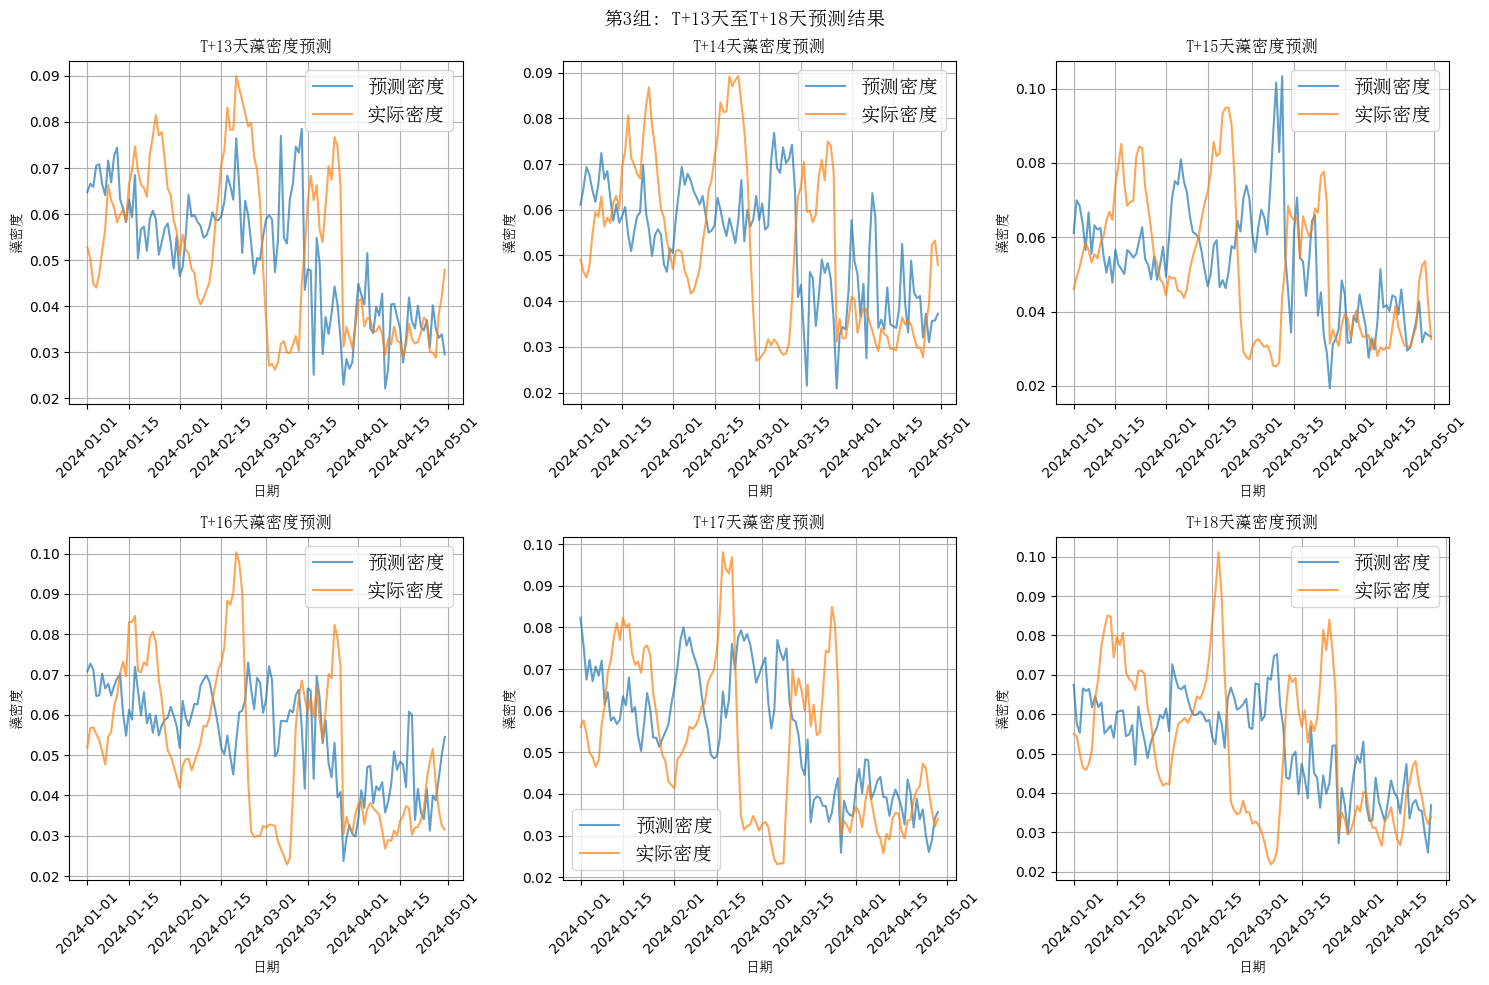

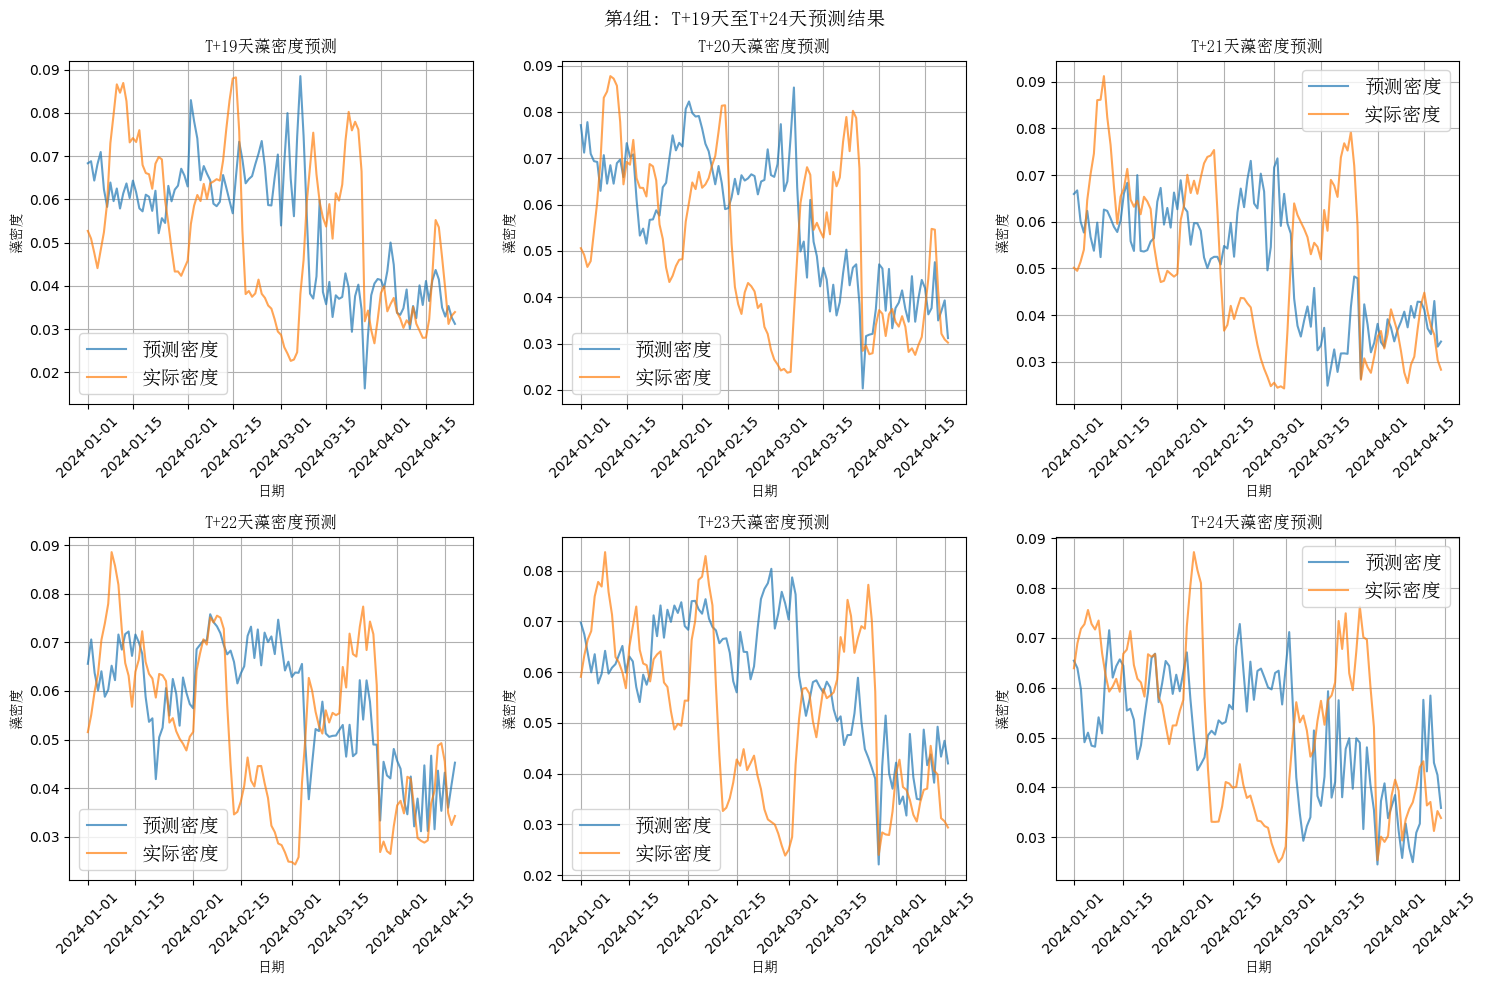

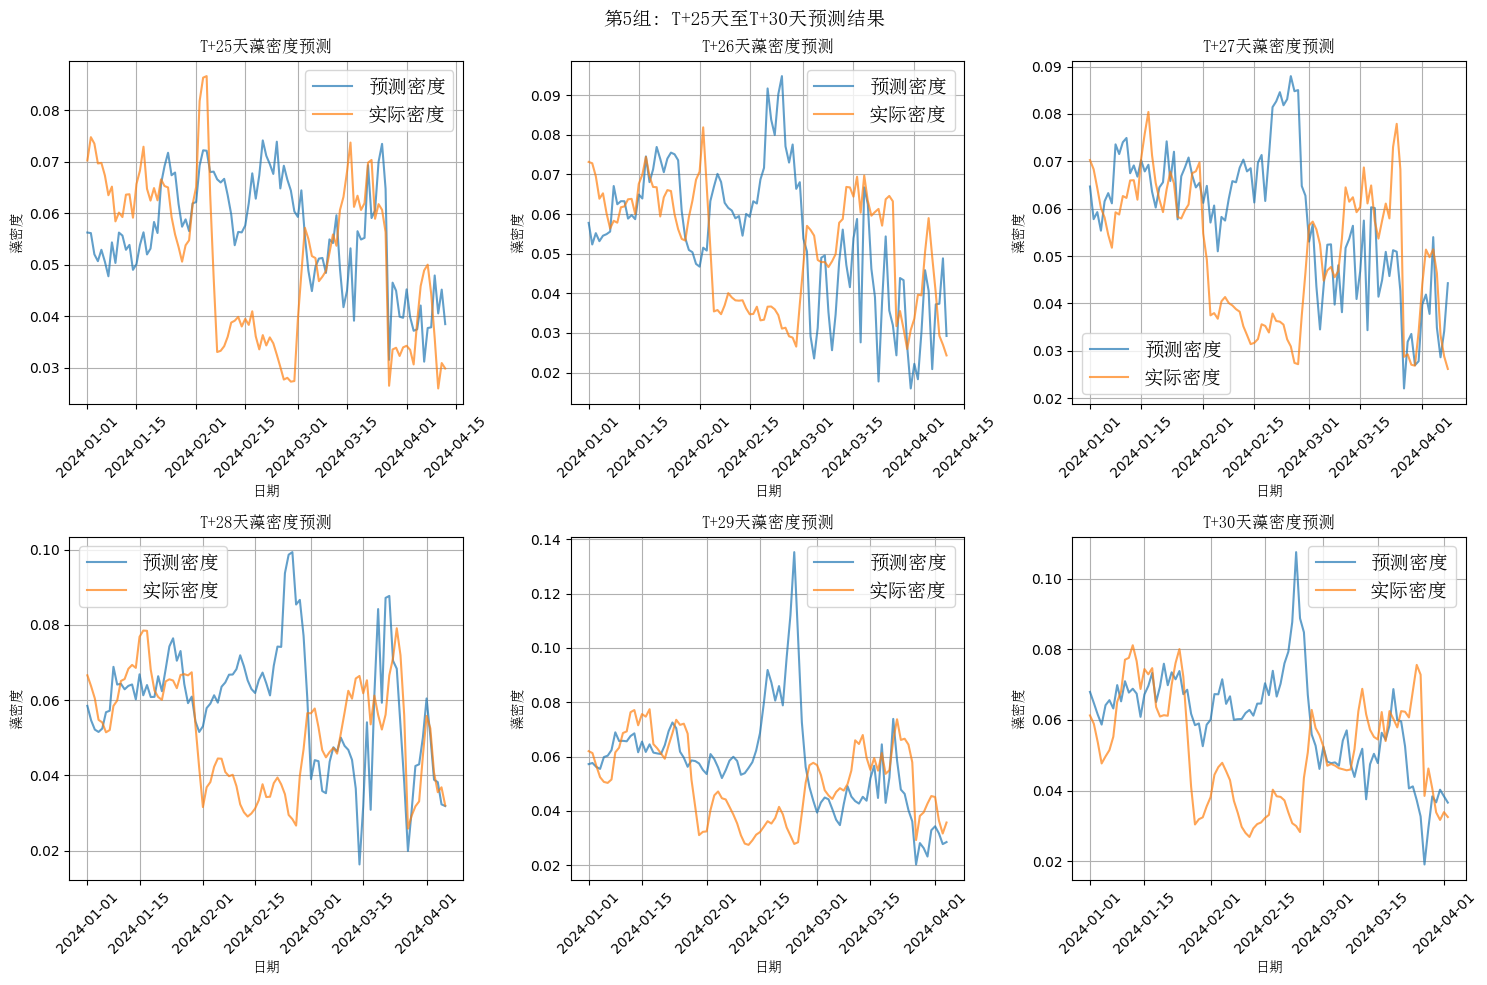

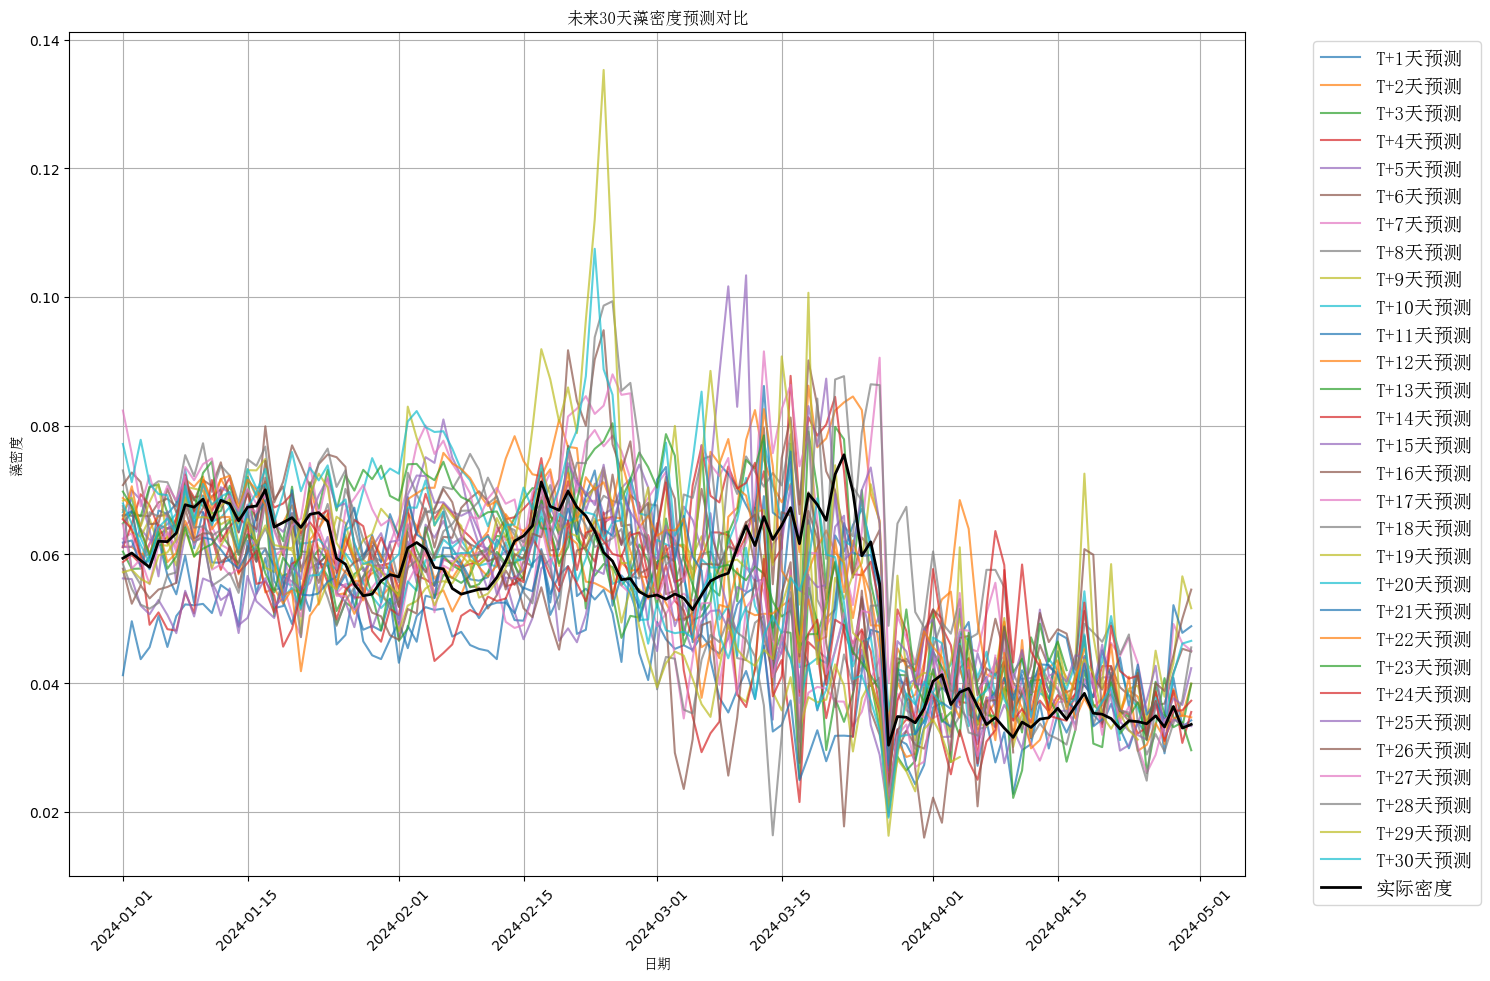

In [6]:
# 计算每个预测天数的RMSE
print("\n2024年藻密度预测的RMSE:")
for days in range(1, 31):  # 改为1-30天
    # 收集所有日期的预测值和实际值
    predictions = []
    actuals = []
    for date in density_predictions.keys():
        # 确保该天数的预测值存在
        if days in density_predictions[date] and days in density_actuals[date]:
            predictions.append(density_predictions[date][days])
            actuals.append(density_actuals[date][days])
    
    if predictions and actuals:
        density_rmse = np.sqrt(mean_squared_error(actuals, predictions))
        print(f"T+{days}天预测的RMSE: {density_rmse:.4f}")

# 绘制2024年1-5月的预测结果
start_date = '2024-01-01'
end_date = '2024-05-31'

# 获取2024年的预测日期
prediction_dates = []
predictions = []
actuals = []

for date in density_predictions.keys():
    if pd.to_datetime(start_date) <= date <= pd.to_datetime(end_date):
        prediction_dates.append(date)

# 每6天绘制一张图，共5张图
for group in range(5):  # 0-4共5组
    plt.figure(figsize=(15, 10))
    for i in range(6):  # 每组6天
        days = group * 6 + i + 1
        if days <= 30:  # 确保不超过30天
            plt.subplot(2, 3, i+1)
            
            # 只绘制存在预测值和实际值的点
            valid_dates = []
            pred_values = []
            actual_values = []
            
            for date in prediction_dates:
                if days in density_predictions[date] and days in density_actuals[date]:
                    valid_dates.append(date)
                    pred_values.append(density_predictions[date][days])
                    actual_values.append(density_actuals[date][days])
            
            if valid_dates:  # 只在有有效数据时绘图
                plt.plot(valid_dates, pred_values, label='预测密度', alpha=0.7)
                plt.plot(valid_dates, actual_values, label='实际密度', alpha=0.7)
                
                plt.title(f'T+{days}天藻密度预测', fontproperties=chinese_font, fontsize=12)
                plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
                plt.ylabel('藻密度', fontproperties=chinese_font, fontsize=10)
                plt.legend(prop=chinese_font)
                plt.grid(True)
                plt.xticks(rotation=45)
    
    plt.suptitle(f'第{group+1}组: T+{group*6+1}天至T+{min((group+1)*6, 30)}天预测结果', 
                 fontproperties=chinese_font, fontsize=14)
    plt.tight_layout()
    plt.show()

# 单独绘制所有天数的藻密度预测结果对比
plt.figure(figsize=(15, 10))

# 对每个预测天数
for days in range(1, 31):
    valid_dates = []
    pred_values = []
    
    for date in prediction_dates:
        if days in density_predictions[date]:
            valid_dates.append(date)
            pred_values.append(density_predictions[date][days])
    
    if valid_dates:  # 只在有有效数据时绘图
        plt.plot(valid_dates, pred_values, label=f'T+{days}天预测', alpha=0.7)

# 绘制实际值
valid_dates = []
actual_values = []
for date in prediction_dates:
    if 1 in density_actuals[date]:  # 使用T+1天的实际值
        valid_dates.append(date)
        actual_values.append(density_actuals[date][1])

if valid_dates:
    plt.plot(valid_dates, actual_values, label='实际密度', color='black', linewidth=2)

plt.title('未来30天藻密度预测对比', fontproperties=chinese_font, fontsize=12)
plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
plt.ylabel('藻密度', fontproperties=chinese_font, fontsize=10)
plt.legend(prop=chinese_font, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
